In [4]:
##### import packages
#base
import os
import sys
from collections import defaultdict
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import random
import pyreadr
import pandas as pd
import seaborn as sns
%matplotlib inline
%autosave 30

#pyro contingency
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete, Predictive
from pyro.ops.indexing import Vindex
from pyro.infer import MCMC, NUTS
import torch
from torch.distributions import constraints
pyro.enable_validation(True)

#misc
import pickle
import torch.nn.functional as F
import itertools
import time
# import umap
# import plotly
# import plotly.graph_objs as go

# import homebrew modules
import tomtom_models as tm
import tomtom_util as tu

# some useless warnings from seaborn, suppressing here
import warnings
warnings.filterwarnings("ignore")

Autosaving every 30 seconds


In [5]:
# import data
# global tself_norm_all_3d, tself_norm_noauto_3d, tself_raw_all_3d, tself_raw_noauto_3d
# global ttarg_norm_all_3d, ttarg_norm_noauto_3d, ttarg_raw_all_3d, ttarg_raw_noauto_3d
# global tavg_norm_all_3d, tavg_norm_noauto_3d, tavg_raw_all_3d, tavg_raw_noauto_3d

# import pickled data
with open('tomtom_data_preprocessed.pkl','rb') as f:
    [tself_norm_all_3d, tself_norm_noauto_3d, tself_raw_all_3d, tself_raw_noauto_3d,
    ttarg_norm_all_3d, ttarg_norm_noauto_3d, ttarg_raw_all_3d, ttarg_raw_noauto_3d,
    tavg_norm_all_3d, tavg_norm_noauto_3d, tavg_raw_all_3d, tavg_raw_noauto_3d] = pickle.load(f) 

# Grid search through feature-value combinations

1. One vs. Three transitions (all triplet combinations)
2. 0.1-0.9 on each feature
3. group model - classify + sample to get the likelihood of each cluster
4. dimension model - learn individual mixture weight of each component, currently incomplete

All done using modeling/scripts-cluster/stimuli-generation, but code included here

### Group Model

In [6]:
# set model fitting params
tm.K = 3
tm.mtype = 'group'
tm.target = 'self' # 'self','targ','avg'
tm.dtype = 'raw' # 'norm','raw'
tm.auto = 'noauto' # 'noauto','all'
tm.stickbreak = False
tm.optim = pyro.optim.Adam({'lr': 0.0005, 'betas': [0.8, 0.99]})
tm.elbo = TraceEnum_ELBO(max_plate_nesting=1)
dtname = 't{}_{}_{}_3d'.format(tm.target, tm.dtype, tm.auto)
data = globals()[dtname]
seed_grp, mapl_grp, mem_grp, lp_grp, guide_grp = tm.tomtom_svi(data,return_guide = True)

running SVI with: tself_raw_noauto_3d
seed = 63, initial_loss = 16388.033203125
..............................
 final loss: -1032.6170654296875



In [7]:
# defining sparse-input model
@config_enumerate
def model_multi_obs_grp(obsmat):
    # some parameters can be directly derived from the data passed
    # K = 2
    nparticipants = data.shape[0]
    nfeatures = data.shape[1] # number of rows in each person's matrix
    ncol = data.shape[2]
    
    # Background probability of different groups
    if tm.stickbreak:
        # stick breaking process for assigning weights to groups
        with pyro.plate("beta_plate", K-1):
            beta_mix = pyro.sample("weights", dist.Beta(1, 10))
        weights = tm.mix_weights(beta_mix)
    else:
        weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(tm.K)))
    # declare model parameters based on whether the data are row-normalized
    if tm.dtype == 'norm':
        pass
#         with pyro.plate('components', K):
#             # concentration parameters
#             concentration = pyro.sample('concentration',
#                                         dist.Gamma(2 * torch.ones(nfeatures,ncol), 1/3 * torch.ones(nfeatures,ncol)).to_event(2))
        
#         # implementation for the dirichlet based model is not complete!!!!
#         with pyro.plat('data',obsmat.shape[0]):
#             assignment = pyro.sample('assignment', dist.Categorical(weights))
#             #d = dist.Dirichlet(concentration[assignment,:,:].clone().detach()) # .detach() might interfere with backprop
#             d = dist.Dirichlet(concentration[assignment,i,:])
#             pyro.sample('obs', d.to_event(1), obs=obsmat)

    elif tm.dtype == 'raw':
        with pyro.plate('components', tm.K):
            alphas = pyro.sample('alpha', dist.Gamma(2 * torch.ones(nfeatures,ncol), 1/3 * torch.ones(nfeatures,ncol)).to_event(2))
            betas = pyro.sample('beta', dist.Gamma(2 * torch.ones(nfeatures,ncol), 1/3 * torch.ones(nfeatures,ncol)).to_event(2))

        assignment = pyro.sample('assignment', dist.Categorical(weights))
        # expand assignment to make dimensions match
        for r in np.arange(obsmat.shape[0]):
            rowind = obsmat[r,1].type(torch.long)
            colind = obsmat[r,2].type(torch.long)
            d = dist.Beta(alphas[assignment,rowind,colind],betas[assignment,rowind,colind])
            pyro.sample('obs_{}'.format(r), d, obs = obsmat[r,0])
        

In [8]:
# multi_obs classifier
guide_trace = poutine.trace(guide_grp).get_trace(data)  # record the globals
trained_model_multi = poutine.replay(model_multi_obs_grp, trace = guide_trace)

def classifier_multi_obs(obsmat, temperature): # temperature = 1 to sample
    inferred_model = infer_discrete(trained_model_multi, temperature=temperature,
                                    first_available_dim=-1)  # avoid conflict with data plate
    trace = poutine.trace(inferred_model).get_trace(obsmat)
    return trace.nodes["assignment"]["value"]

In [9]:
# Single Feature
# initialize storage
niter = 500
nsteps = np.arange(.1,1,.1).shape[0]
stor_grp = torch.empty(size = [data.shape[1],data.shape[2],nsteps])
stor_grp_prb = torch.empty(size = [data.shape[1],data.shape[2],nsteps,tm.K])
# iterate through all features, each with value .1-.9
for row in np.arange(data.shape[1]):
    for col in np.arange(data.shape[2]):
        step_count = 0
        for step in np.arange(.1,1,.1):
            newdata = torch.tensor([step, row, col]).unsqueeze(0)
            # first MAP classification
            grp = classifier_multi_obs(newdata, temperature = 0)
            stor_grp[row,col,step_count] = grp
            # second use sampling to get group prob
            stor = torch.zeros(niter)
            for it in np.arange(niter):
                stor[it] = classifier_multi_obs(newdata, temperature = 1)
            grp_prb = [(stor == i).sum()/float(len(stor)) for i in np.arange(tm.K)]
            stor_grp_prb[row,col,step_count,:] = torch.tensor(grp_prb)
            step_count += 1

In [ ]:
# # Three Features
# dfr = pd.DataFrame({'row':np.arange(data.shape[1]),'key': 1})
# dfc = pd.DataFrame({'col':np.arange(data.shape[2]),'key': 1})
# coord =pd.merge(dfr,dfc,on='key').drop('key',1) # mapping each cell to their row/col index, just another way to do cartesian product but indexing later is easier
# cellcombo = list(itertools.combinations(np.arange(60),3))
# nstim = 3
# stepcombo = list(itertools.product(np.arange(.1,1,.1), repeat = nstim))
# allsteps = np.arange(.1,1,.1)
# nsteps = allsteps.shape[0]
# # stor_grp_3feat = torch.empty(size = [len(cellcombo),nsteps,nsteps,nsteps])
# # stor_grp_prb_3feat = torch.empty(size = [len(cellcombo),nsteps,nsteps,nsteps,K])

# def combo_3feat(comb):
#     comb_counter = cellcombo.index(comb)
#     #first identify all row and col indices
#     rs = coord.loc[np.array(comb),'row']
#     cs = coord.loc[np.array(comb),'col']
#     # print(comb_counter)
#     stor = torch.empty(size = [nsteps, nsteps, nsteps])
#     stor_prb = torch.empty(size = [nsteps, nsteps, nsteps, K])
#     for step in stepcombo:
#         newdata = torch.tensor(np.stack((step,rs,cs),1))
#         step1 = np.where(allsteps == step[0])[0][0] # can try to make this generalize for arbitrary nstim, seems hard tho
#         step2 = np.where(allsteps == step[1])[0][0]
#         step3 = np.where(allsteps == step[2])[0][0]
#         # first MAP classification
#         grp = classifier_multi_obs(newdata, temperature = 0)
#         stor[step1,step2,step3] = grp
#         #second use sampling to get group prob
#         s = torch.zeros(niter)
#         for it in np.arange(niter):
#             s[it] = classifier_multi_obs(newdata, temperature = 1)
#         grp_prb = [(s == i).sum()/float(len(s)) for i in np.arange(K)]
#         stor_prb[step1,step2,step3,:] = torch.tensor(grp_prb)
#     print('Finished combo {}'.format(comb_counter))
#     return stor, stor_prb

# import multiprocessing

# ta = time.time()
# pool = multiprocessing.Pool()
# pool_out = pool.map(combo_3feat, cellcombo[0:20])
# stor_grp_3feat = torch.stack([tt[0] for tt in pool_out])
# stor_grp_prb_3feat = torch.stack([tt[1] for tt in pool_out])
# print(time.time() - ta)
# print(stor_grp_3feat.shape)
# print(stor_grp_prb_3feat.shape)
# print(stor_grp_prb_3feat[5])

## Dimension Model

In [62]:
# set model fitting params
tm.K = 3
tm.mtype = 'dim'
tm.target = 'self' # 'self','targ','avg'
tm.dtype = 'raw' # 'norm','raw'
tm.auto = 'noauto' # 'noauto','all'
tm.stickbreak = False
tm.optim = pyro.optim.Adam({'lr': 0.0005, 'betas': [0.8, 0.99]})
tm.elbo = TraceEnum_ELBO(max_plate_nesting=1)

dtname = 't{}_{}_{}_3d'.format(tm.target, tm.dtype, tm.auto)
data = globals()[dtname]
seed_dim, mapl_dim, lp_dim, guide_dim = tm.tomtom_svi(data,return_guide = True)

In [174]:
# model fitting
pyro.clear_param_store()
#declare dataset to be modeled
dtname = 't{}_{}_{}_3d'.format(target, dtype, auto)
print("running SVI with: {}".format(dtname))
# data = globals()[dtname]
data = vars()[dtname]

loss, seed = min((initialize(seed,model,data), seed) for seed in range(100))
initialize(seed,model,data)
print('seed = {}, initial_loss = {}'.format(seed, loss))

# gradient_norms = defaultdict(list)
# for name, value in pyro.get_param_store().named_parameters():
#     value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(3000):
    loss = svi.step(data)
    #print(loss)
    losses.append(loss)
    if i % 100 == 0:
        print('.',end = '')
#             print(loss)
print('\n final loss: {}\n'.format(losses[-1]))

running SVI with: tself_raw_noauto_3d
seed = 37, initial_loss = 16926.279296875
..............................
 final loss: -1246.4873046875



In [181]:
map_dim

{'topic_weights': tensor([0.5256, 0.4224, 0.7553], grad_fn=<ExpandBackward>),
 'topic_a': tensor([[[ 3.8767,  2.2639,  1.7345,  2.4200],
          [ 1.8958,  1.7205,  6.2372,  1.8286],
          [ 1.5057,  2.8178,  1.7273,  1.2591],
          [ 1.1103,  3.4179,  1.1312,  0.9376],
          [ 3.1478,  1.3969,  1.4844,  3.3614],
          [ 1.3401,  2.2661,  7.9908,  7.9658],
          [ 1.4839,  1.0624,  1.9212,  1.1917],
          [ 1.4579,  1.6259, 10.5371, 14.1060],
          [ 2.5557,  1.8333,  2.0099,  1.9113],
          [ 1.4944,  1.1536,  7.7213,  3.7645],
          [ 1.3890,  1.2069,  2.8325,  1.5430],
          [ 1.6162,  1.4605,  3.4062,  2.4597],
          [ 1.0064,  1.4142,  1.9132,  1.9076],
          [ 5.1878,  1.5064,  1.0376,  1.5434],
          [ 3.8488,  1.3164,  1.7821,  1.5674]],
 
         [[ 6.7035,  2.5486,  2.2294,  2.5348],
          [ 1.6712,  1.4842,  8.0454,  3.2342],
          [ 1.4314,  3.5516,  1.8442,  2.2266],
          [ 0.9618,  5.6168,  1.9249,  1.659

In [110]:
# recording output from group model fitting for later use
seed_dim = seed
map_dim = global_guide(data)
guide_dim = global_guide

# store a copy of MAP without participant topics for new inference purposes
map_dim_nopt = map_dim.copy()
pt = map_dim_nopt.pop('participant_topics')

In [169]:
# scarse obs model and guide
@config_enumerate
def model_multi_obs_dim(obsmat):
    # some parameters can be directly derived from the data passed
    # K = 2
#     nparticipants = data.shape[0]
#     nfeatures = data.shape[1] # number of rows in each person's matrix
#     ncol = data.shape[2]
    num_topics = K
    nparticipants = data.shape[0]
    nfeatures = data.shape[1] # number of rows in each person's matrix
    ncol = data.shape[2]

    if dtype == 'norm':
        pass
    elif dtype == 'raw':
            
        with pyro.plate('topic', num_topics):
            # sample a weight and value for each topic
            topic_weights = pyro.sample("topic_weights", dist.Gamma(1. / num_topics, 1.))
            topic_a = pyro.sample("topic_a", dist.Gamma(2 * torch.ones(nfeatures,ncol),
                                                             1/3 * torch.ones(nfeatures,ncol)).to_event(2))
            topic_b = pyro.sample("topic_b", dist.Gamma(2 * torch.ones(nfeatures,ncol),
                                                       1/3 * torch.ones(nfeatures,ncol)).to_event(2))

        # sample each participant's idiosyncratic topic mixture
        participant_topics = pyro.sample("new_participant_topic", dist.Dirichlet(topic_weights))
        transition_topics = pyro.sample("new_transition_topic", dist.Categorical(participant_topics),
                                        infer={"enumerate": "parallel"})
        out = dist.Beta(topic_a[transition_topics], topic_b[transition_topics]).to_event(2)
        for r in np.arange(obsmat.shape[0]):
            rowind = obsmat[r,1].type(torch.long)
            colind = obsmat[r,2].type(torch.long)
            d = dist.Beta(topic_a[transition_topics,rowind,colind],topic_b[transition_topics,rowind,colind])
            pyro.sample('obs_{}'.format(r), d, obs = obsmat[r,0])
            
def new_guide(obsmat):
    # Global variables.
    with poutine.block(hide_types=["param"]):  # Keep our learned values of global parameters.
        map_dim_nopt
        
    participant_topics = pyro.sample("new_participant_topic", dist.Dirichlet(map_dim_nopt['topic_weights']))
    p_t_probs = pyro.param('p_t_probs', participant_topics)
    transition_topics = pyro.sample("new_transition_topic", dist.Categorical(p_t_probs),
                                        infer={"enumerate": "parallel"})

# new_guide = AutoDelta(poutine.block(model_multi_obs_dim, expose = ['new_participant_topic']))
    
def initialize_multi_obs_dim(seed, model, guide, data):
    global svi
    pyro.set_rng_seed(seed)
    if 'p_t_probs' in pyro.get_param_store().keys():
                    pyro.get_param_store().__delitem__('p_t_probs')
    svi = SVI(model, guide, optim, loss = elbo)
    return svi.loss(model, guide, data)


In [88]:
nsteps = np.arange(.1,1,.1).shape[0]
stor_dim_seed = torch.empty(size = [data.shape[1],data.shape[2],nsteps])
stor_dim_init_loss = torch.empty(size = [data.shape[1],data.shape[2],nsteps])
stor_dim_final_loss = torch.empty(size = [data.shape[1],data.shape[2],nsteps])
stor_dim_prb = torch.empty(size = [data.shape[1],data.shape[2],nsteps,K])
# iterate through all features, each with value .1-.9
for row in np.arange(data.shape[1]):
    for col in np.arange(data.shape[2]):
#         if row == col:
#             pass
#         else:
        step_count = 0
        print('({},{})'.format(row,col))
        for step in np.arange(.1,1,.1):
            newdata = torch.tensor([step, row, col]).unsqueeze(0)
            if 'p_t_probs' in pyro.get_param_store().keys():
                pyro.get_param_store().__delitem__('p_t_probs')

            loss, seed = min((initialize_multi_obs_dim(seed,model_multi_obs_dim,new_guide,newdata), seed) for seed in range(100))
            initialize_multi_obs_dim(seed,model_multi_obs_dim,new_guide,newdata)
            stor_dim_seed[row, col, step_count] = seed
            stor_dim_init_loss[row,col,step_count] = loss
            for i in range(1000):
                loss = svi.step(newdata)
            stor_dim_final_loss[row,col,step_count] = loss
            stor_dim_prb[row,col,step_count,:] = pyro.get_param_store()['p_t_probs']
            step_count += 1

(0,0)
(0,1)
(0,2)
(0,3)
(1,0)
(1,1)
(1,2)
(1,3)
(2,0)
(2,1)
(2,2)
(2,3)
(3,0)
(3,1)
(3,2)
(3,3)
(4,0)
(4,1)
(4,2)
(4,3)
(5,0)
(5,1)
(5,2)
(5,3)
(6,0)
(6,1)
(6,2)
(6,3)
(7,0)
(7,1)
(7,2)
(7,3)
(8,0)
(8,1)
(8,2)
(8,3)
(9,0)
(9,1)
(9,2)
(9,3)
(10,0)
(10,1)
(10,2)
(10,3)
(11,0)
(11,1)
(11,2)
(11,3)
(12,0)
(12,1)
(12,2)
(12,3)
(13,0)
(13,1)
(13,2)
(13,3)
(14,0)
(14,1)
(14,2)
(14,3)


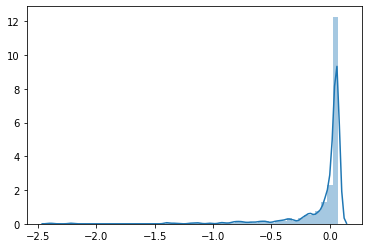

In [92]:
sns.distplot((stor_dim_final_loss - stor_dim_init_loss))

In [194]:
# with open('tomtom_scarce_param.pkl','wb') as f:
#     pickle.dump([stor_grp, stor_grp_prb,
#                 stor_dim_seed, stor_dim_init_loss, stor_dim_final_loss, stor_dim_prb],f)

In [170]:
newdata = torch.tensor([[.9,1,1],
                       [.9,2,2],
                       [.1,3,3]])
if 'p_t_probs' in pyro.get_param_store().keys():
    pyro.get_param_store().__delitem__('p_t_probs')

loss, seed = min((initialize_multi_obs_dim(seed,model_multi_obs_dim,new_guide,newdata), seed) for seed in range(100))
initialize_multi_obs_dim(seed,model_multi_obs_dim,new_guide,newdata)
print(loss)
for i in range(1000):
    loss = svi.step(newdata)
print(loss)
pyro.get_param_store()['p_t_probs']


839.7295532226562


ValueError: can't optimize a non-leaf Tensor

In [156]:
pyro.get_param_store().keys()


dict_keys(['AutoDelta.topic_weights', 'AutoDelta.topic_a', 'AutoDelta.topic_b', 'AutoDelta.participant_topics', 'AutoDelta.new_participant_topic', 'topic_a', 'topic_b', 'topic_weights'])

In [153]:
pyro.get_param_store().setdefault('topic_a',pyro.get_param_store()['AutoDelta.topic_a'])
pyro.get_param_store().setdefault('topic_b',pyro.get_param_store()['AutoDelta.topic_b'])
pyro.get_param_store().setdefault('topic_weights',pyro.get_param_store()['AutoDelta.topic_weights'])

tensor([0.5256, 0.4224, 0.7553], grad_fn=<AddBackward0>)

In [157]:
pyro.get_param_store()['AutoDelta.new_participant_topic']

tensor([0.3364, 0.3311, 0.3325], grad_fn=<DivBackward0>)

In [ ]:
@config_enumerate
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))

    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)

In [ ]:
@config_enumerate
def full_guide(data):
    # Global variables.
    with poutine.block(hide_types=["param"]):  # Keep our learned values of global parameters.
        global_guide(data)

    # Local variables.
    with pyro.plate('data', len(data)):
        assignment_probs = pyro.param('assignment_probs', torch.ones(len(data), K) / K,
                                      constraint=constraints.unit_interval)
        pyro.sample('assignment', dist.Categorical(assignment_probs))